In [1]:
import pandas as pd
import EDA
import preprocessing
import classification

column_credit = ['CustomerID', 'CheckingAccountBalance', 'DebtsPaid', 'SavingsAccountBalance',
                 'CurrentOpenLoanApplications']
df_credit = pd.read_csv('ds-credit.tsv', sep='\s+', header=-1, names=column_credit)

column_app = ['CustomerID', 'LoanPayoffPeriodInMonths', 'LoanReason', 'RequestedAmount', 'InterestRate',
              'Co-Applicant']
df_app = pd.read_csv('ds-app.tsv', sep='\s+', header=-1, names=column_app)

column_borrower = ['CustomerID', 'YearsAtCurrentEmployer', 'YearsInCurrentResidence', 'Age', 'RentOrOwnHome',
                   'TypeOfCurrentEmployment', 'NumberOfDependantsIncludingSelf']
df_borrower = pd.read_csv('ds-borrower.csv', sep='\s+', index_col=False, names=column_borrower, header=0)

column_result = ['CustomerID', 'WasTheLoanApproved']
df_result = pd.read_csv('ds-result.tsv', sep='\s+', header=-1, names=column_result)
df_result = df_result.drop_duplicates()  # Drop the duplicated results

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

In [3]:
na = preprocessing.NA(df_borrower)
na.to_num('CustomerID')
df_borrower = na.drop('CustomerID')

na = preprocessing.NA(df_result)
na.to_num('CustomerID')
df_result = na.drop('CustomerID')

mg = preprocessing.Merge([df_credit, df_app, df_borrower, df_result])
df_all = mg.transform('CustomerID')
df = df_all.loc[(df_all.WasTheLoanApproved == 'Y') | (df_all.WasTheLoanApproved == 'N')].dropna()
df['Age'] = pd.to_numeric(df.Age)
df['LoanPayoffPeriodInMonths'] = pd.to_numeric(df.LoanPayoffPeriodInMonths)

In [4]:
df = df.drop('CustomerID',1)
df1 = df.drop(['RequestedAmount','Age','WasTheLoanApproved',],1)

In [5]:
en = preprocessing.Encode()
en.one_hot(df1)
df2 = en.encoder.transform(df1)
df = preprocessing.Encode().ordinal(df)

x = pd.concat([df.RequestedAmount.reset_index(drop=True), df.Age.reset_index(drop=True), pd.DataFrame(df2.toarray())],1) 
y = df.iloc[:, -1:].values.reshape(-1,1)

In [6]:
from sklearn.ensemble import RandomForestClassifier

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


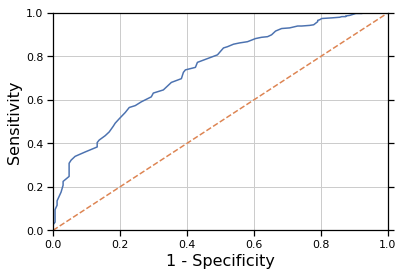

0.7402629898704033


In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
classification.Roc(rf, 'predict_proba').plot(x, y)

In [ ]:
classification.Roc(rf, 'predict_proba').plot(x, y)

In [13]:
from xgboost import XGBClassifier

In [11]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=800,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)

NameError: name 'XGBClassifier' is not defined

In [12]:
classification.Roc(xgb1, 'predict_proba').plot(x, y)

NameError: name 'xgb1' is not defined

In [20]:
from imblearn.over_sampling import SMOTE

In [21]:
from sklearn.model_selection import train_test_split

In [23]:
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.2, random_state=42)

In [47]:
rf = RandomForestClassifier(n_estimators=800, random_state=42)

In [48]:
rf.fit(xtr, ytr)

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [49]:
rf.score(xte, yte)

0.7572815533980582

In [28]:
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_sample(xtr, ytr)

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
rf.fit(x_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [51]:
rf.score(xte, yte)

0.6893203883495146

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
svc = svm.SVC(gamma="scale")